# <font color=#323232>Tweet Sentiment Analysis</font>

### <font color=#333333>1. Data | Libraries</font>
### <font color=#333333>2. Data Exploration & Data-Preprocessing</font>
### <font color=#333333>3. Feature Matrix Creation | Oversampling</font>
#### <font color=#404040>&emsp;&emsp;3.1 Feature Matrix Creation</font>
#### <font color=#404040>&emsp;&emsp;3.2 Oversampling</font>
### <font color=#333333>4. Tweet Classification</font>
#### <font color=#404040>&emsp;&emsp;4.1 Helper Functions</font>
#### <font color=#404040>&emsp;&emsp;4.2 Classification Models</font>
#### <font color=#404040>&emsp;&emsp;&emsp;&emsp;4.2.1 SVM</font>
#### <font color=#404040>&emsp;&emsp;&emsp;&emsp;4.2.2 KNN</font>
#### <font color=#404040>&emsp;&emsp;&emsp;&emsp;4.2.3 Decision Trees</font>
#### <font color=#404040>&emsp;&emsp;&emsp;&emsp;4.2.4 Random Forest</font>
#### <font color=#404040>&emsp;&emsp;&emsp;&emsp;4.2.5 AdaBoost</font>
#### <font color=#404040>&emsp;&emsp;&emsp;&emsp;4.2.6 Naive Bayes</font>
#### <font color=#404040>&emsp;&emsp;4.3 Export Vectorizer and ML Model</font>


***

# 1. Import Libraries | Datasets

In [1]:
import pandas as pd
import numpy as np
import os, warnings
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.exceptions import DataConversionWarning
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

warnings.filterwarnings(action='ignore', category=DataConversionWarning) # ignore some Scikit Learn warnings
pd.set_option("display.max_columns", None) # enables the printing of all columns

raw_df = pd.read_csv('../datasets/tweet_emotions.csv')

# 2. Data Exploration & Data-Preprocessing

### Dataframe dimensions

In [2]:
print(f'Length of df {len(raw_df)}, number of columns {len(raw_df.columns)}, dimensions {raw_df.shape}, number of elements {raw_df.size}')

Length of df 40000, number of columns 3, dimensions (40000, 3), number of elements 120000


### Dataframe Overview

In [3]:
raw_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 7.7 MB


#### Statistics help us get some insights and allows for an initial inspection of outliers 
##### In this case it is not very helpful

In [4]:
raw_df.describe(include='all')

,tweet_id,sentiment,content
count,4.000000e+04,40000,40000
unique,NaN,13,39827
top,NaN,neutral,I just received a mothers day card from my lov...
freq,NaN,8638,14
mean,1.845184e+09,NaN,NaN
std,1.188579e+08,NaN,NaN
min,1.693956e+09,NaN,NaN
25%,1.751431e+09,NaN,NaN
50%,1.855443e+09,NaN,NaN
75%,1.962781e+09,NaN,NaN


In [5]:
raw_df.head(5)

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


### Handle Missing Values in Data
##### Note: Missing Data could be removed by:
    1) Removing the entire row that contains at least one Null Value
    2) Data Imputation - Fill the missing data with average/median of the column

In [6]:
print(raw_df.isna().sum())
print("No missing values after all :)")

tweet_id     0
sentiment    0
content      0
dtype: int64
No missing values after all :)


### Remove Duplication

In [7]:
df_size = raw_df.shape[0]
raw_df.drop_duplicates(keep=False, inplace=True)
df_size_dup = raw_df.shape[0]
print(f'Duplicate Rows Deleted {df_size - df_size_dup}, Old size: {df_size}, New size: {df_size_dup}')

Duplicate Rows Deleted 0, Old size: 40000, New size: 40000


### Class Imbalance
> **Note**: Oversampling will be used later in order to balance the dataset

In [8]:
print("Sentiment Label has", len(raw_df['sentiment'].unique()),"unique values.")
print(raw_df['sentiment'].value_counts())

Sentiment Label has 13 unique values.
neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64


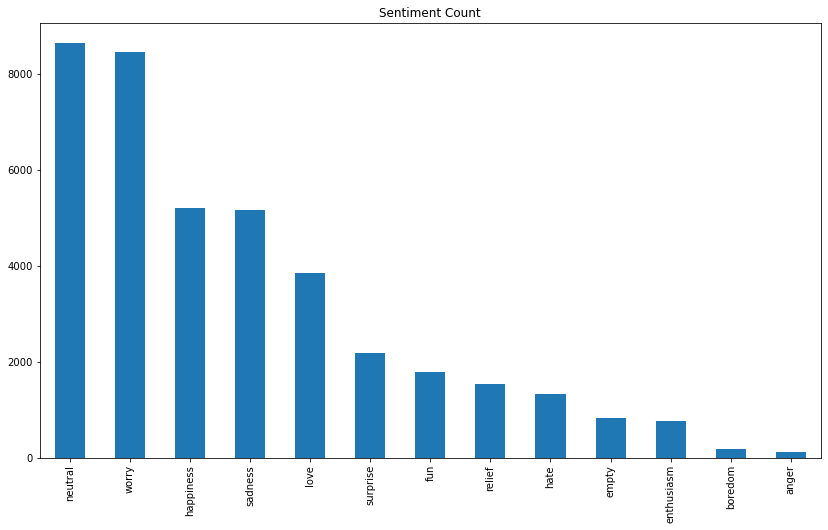

In [9]:
ax = raw_df['sentiment'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Sentiment Count")

### Content Column Character Count
> **Note**: Content texts below a given threshold (i.e. **character_count < 5**) will be considered **outliers**

In [10]:
raw_df['content_char_count'] = raw_df['content'].str.len()

raw_df['content_char_count'].describe()

count    40000.000000
mean        73.405550
std         36.558015
min          1.000000
25%         43.000000
50%         69.000000
75%        103.000000
max        167.000000
Name: content_char_count, dtype: float64

In [11]:
old_shape = raw_df.shape[0]
raw_df = raw_df[raw_df['content_char_count'] >= 5]
print(f'Rows Removed for having low number of characters: {old_shape-raw_df.shape[0]}')

Rows Removed for having low number of characters: 4


### Data Visualization

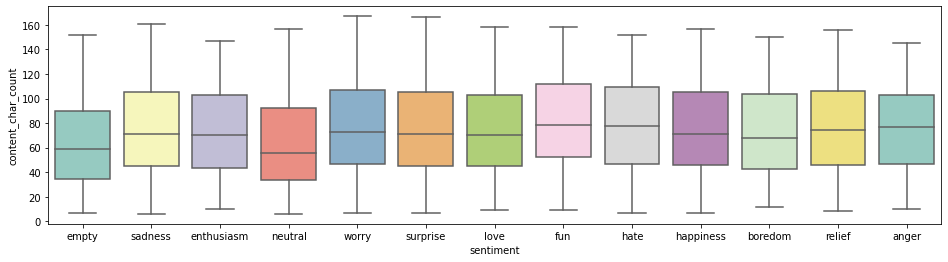

In [12]:
plt.figure(figsize=(16,4))
ax = sns.boxplot(x="sentiment",y="content_char_count",data=raw_df, palette="Set3")
plt.show()

In [13]:
import re # Regex Library 

def replace_emoticons(txt):

    # Replace emoticons with a word describing the emoticon
    emoticons_happy = set([':-)', ':)', ':]', ':3', '=]', '=)'])

    emoticons_sad = set([':(',"=[" ,":'(", ':@', ':-(', ':[', ':-[', '>.<', ':-c',':c'])
    
    emoticons_surprised = set([':O', ':o', ':-o', ':-O'])

    words = txt.split()
    new_w = []
    for w in words:
        if w in emoticons_happy:
            new_w.append("happy")
        elif w in emoticons_sad:
            new_w.append("sad") 
        elif w in emoticons_surprised:
            new_w.append("surprised") 
        else:
            new_w.append(w)
    txt = " ".join(new_w)
    return txt


def data_cleaning(txt):
    txt = replace_emoticons(txt)     # replace emoticons with a word describing the emoticon
    txt = re.sub('@[^\\s]+', '', txt) # remove usernames
    txt = re.sub('RT[\\s]+', '', txt) # remove retweet 'RT'
    txt = re.sub('#', '', txt)       # remove '#'
    txt = re.sub('((www\\.[^\\s]+)|(https?://[^\\s]+))', '', txt)  # remove URLs inside the text
    
    return txt

print('Average word character count BEFORE data cleaning is',raw_df['content_char_count'].mean())
raw_df['content'] = raw_df['content'].apply(data_cleaning)
raw_df['content_char_count'] = raw_df['content'].str.len()
print('Average word character count AFTER data cleaning is',raw_df['content_char_count'].mean())

Average word character count BEFORE data cleaning is 73.41279127912792
Average word character count AFTER data cleaning is 66.1998699869987


In [14]:
# Perform the same operation as before and remove rows with Char Count <5
old_shape = raw_df.shape[0]
raw_df = raw_df[raw_df['content_char_count'] >= 5]
print(f'Rows Removed for having low number of characters: {old_shape-raw_df.shape[0]}')

Rows Removed for having low number of characters: 106


### Tweet Id and the Character count columns are redundant

In [15]:
raw_df = raw_df[['content','sentiment']]

In [16]:
raw_df.head(5)

,content,sentiment
0,i know i was listenin to bad habit earlier an...,empty
1,Layin n bed with a headache ughhhh...waitin on...,sadness
2,Funeral ceremony...gloomy friday...,sadness
3,wants to hang out with friends SOON!,enthusiasm
4,We want to trade with someone who has Houston...,neutral


# 3. Feature Matrix Creation - Oversampling

### 3.1 Feature Matrix Creation
> ### Implementations:
>    * Matrix Vectorization using **Bag of Words (BoW)** 
>        * Convert a collection of text documents to a matrix of token counts
>        * Ignore specific terms (i.e. stop words) because they don't hold any value
>        * Make every Character lowercase, because letter Capitalization doesn't matter in this specific implementation
>    * **Tf-idf Transformation**, in plain terms a word that occurs many times has less significance (weight) in the end result (i.e. the word 'the', 'a', 'to' etc.), following the zipf's law

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_validate

import warnings
warnings.filterwarnings('always')

final_vectorizer_params = {
    "smooth_idf": True,
    "analyzer": 'word',
    "stop_words": 'english',
    "lowercase": True,
    "ngram_range": (1,2),
    "max_features": 1200,
}

tfidf_vectorizer = TfidfVectorizer(**final_vectorizer_params)

train_df = raw_df.copy()
print(train_df.shape[0])

X = train_df['content'].copy()
y = train_df['sentiment'].copy()
X, X_val, y, y_val = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=True)
X = tfidf_vectorizer.fit_transform(X)
X_val = tfidf_vectorizer.transform(X_val)
print(X.shape[0])
print(X_val.shape[0])

39890
33906
5984


### 3.2 OverSampling - Handle Class Imbalance

> Methods to be tested in order to select features:
> * Synthetic Minority Oversampling Technique (**SMOTE**)
>      * An algorithm that synthesizes elements for the minority class
>      * Removing the instances of the majority class of each pair increases the space between the two classes
> * **ADASYN** - generalized form of the SMOTE algorithm.

In [23]:
from imblearn.over_sampling import SMOTE, ADASYN

oversample = ADASYN(sampling_strategy='minority', random_state=8)

for i in range(11):
    X,y = oversample.fit_resample(X, y)

print("New dataset shape",X.shape)

New dataset shape (96926, 1200)


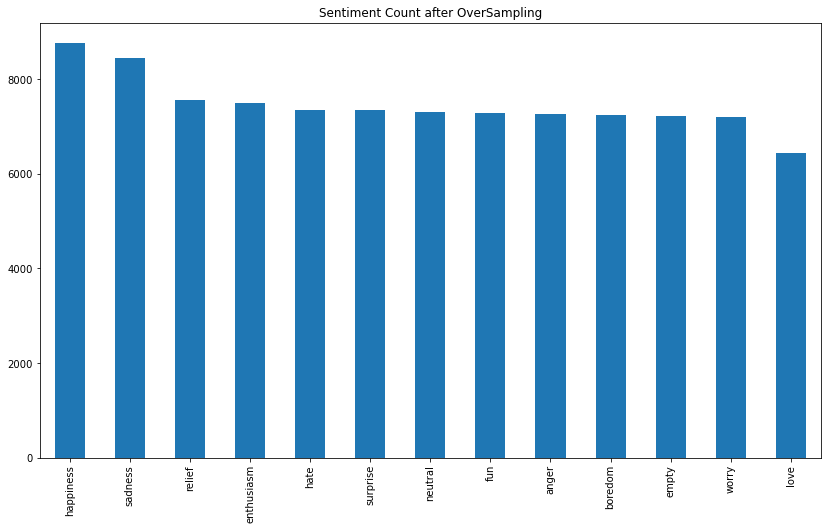

In [24]:
ax = y.value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Sentiment Count after OverSampling")

# 4. Tweet Classification

## 4.1 Helper Functions
>   * Confusion Matrix
>   * Hyperparameter Tuning (with Grid Search Optimization)
>   * 5-fold Cross Validation
>   * Model Training

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def get_confusion_matrix(y, y_p):
    cm = confusion_matrix(y, y_p)
    fig, ax = plt.subplots(figsize=(12,12))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(raw_df['sentiment'].sort_values().unique()))
    disp.plot(ax=ax)
    plt.show()
    return

def hyperparameter_tuning(model, params):
    search = GridSearchCV(model, params, n_jobs=-1, verbose=1, cv=2)
    search.fit(X, y)
    print(" Results from Grid Search " )
    print("\n The best estimator across ALL searched params:\n",search.best_estimator_)
    print("\n The best score across ALL searched params:\n",search.best_score_)
    print("\n The best parameters across ALL searched params:\n",search.best_params_)
    return search.best_estimator_

def model_validation(model):
    results = cross_validate(model, X, y, cv=5, scoring=('accuracy', 'precision_macro', 'recall_macro', 'f1_macro'))
    return results
                              
def train_model(model):
    res = model.fit(X, y)
    predicted = model.predict(X_val)
    result = np.mean(predicted == y_val)
    c_report = classification_report(y_val,predicted)
    predicted_train = model.predict(X)
    print("Accuracy Score on training set is", round(np.mean(predicted_train == y)*100, 2), "%")
    print("Accuracy Score on validation set is", round(result*100, 2), "%")
    get_confusion_matrix(y_val, predicted)
    return res, c_report

## 4.2 Classification Models

### 4.2.1 SVM Classifier

Fitting 2 folds for each of 10 candidates, totalling 20 fits
 Results from Grid Search 

 The best estimator across ALL searched params:
 SVC(C=1.2, kernel='poly')

 The best score across ALL searched params:
 0.4131502383261457

 The best parameters across ALL searched params:
 {'C': 1.2, 'decision_function_shape': 'ovr', 'kernel': 'poly'}
Cross Validation results {'fit_time': array([480.03425813, 442.09284091, 470.02869248, 510.9802618 ,
       511.8447125 ]), 'score_time': array([51.5676806 , 58.41311765, 45.10302663, 44.6046865 , 44.34785843]), 'test_accuracy': array([0.56886413, 0.49089502, 0.45499097, 0.41666237, 0.4236781 ]), 'test_precision_macro': array([0.60640567, 0.62904465, 0.6437302 , 0.66498729, 0.63926889]), 'test_recall_macro': array([0.56376431, 0.48630196, 0.45147607, 0.41441224, 0.42256711]), 'test_f1_macro': array([0.54131468, 0.50973385, 0.48713205, 0.46210992, 0.46091635])}
Accuracy Score on training set is 69.44 %
Accuracy Score on validation set is 19.52 %


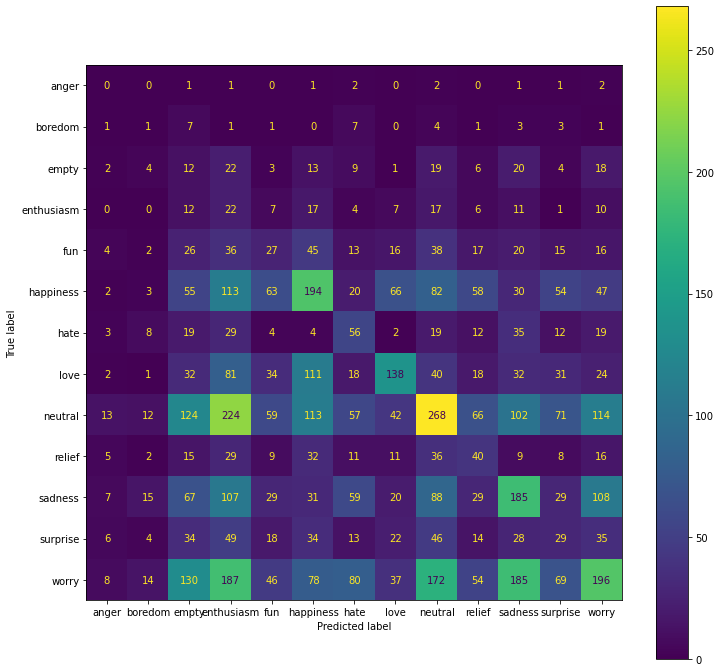

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        11
     boredom       0.02      0.03      0.02        30
       empty       0.02      0.09      0.04       133
  enthusiasm       0.02      0.19      0.04       114
         fun       0.09      0.10      0.09       275
   happiness       0.29      0.25      0.27       787
        hate       0.16      0.25      0.20       222
        love       0.38      0.25      0.30       562
     neutral       0.32      0.21      0.26      1265
      relief       0.12      0.18      0.15       223
     sadness       0.28      0.24      0.26       774
    surprise       0.09      0.09      0.09       332
       worry       0.32      0.16      0.21      1256

    accuracy                           0.20      5984
   macro avg       0.16      0.16      0.15      5984
weighted avg       0.27      0.20      0.22      5984



In [29]:
from sklearn.svm import SVC

svc = SVC()

param_grid = {
    "kernel": ['linear', 'poly'],
    "C": [0.6, 0.8, 1, 1.2, 1.4],
    "decision_function_shape": ['ovr']
}
best_model = hyperparameter_tuning(svc, param_grid)
results = model_validation(best_model)
print("Cross Validation results", results)
final_model, report = train_model(best_model)
print(report)

### 4.2.2 KNN

Fitting 2 folds for each of 2 candidates, totalling 4 fits
 Results from Grid Search 

 The best estimator across ALL searched params:
 KNeighborsClassifier(n_neighbors=3)

 The best score across ALL searched params:
 0.27462187648309017

 The best parameters across ALL searched params:
 {'n_neighbors': 3}
Cross Validation results {'fit_time': array([0.06241679, 0.06289625, 0.06249952, 0.06242847, 0.06348634]), 'score_time': array([13.84759498, 13.86397958, 13.92871594, 13.88208222, 13.87739849]), 'test_accuracy': array([0.46074487, 0.33484653, 0.31343823, 0.28594274, 0.29068868]), 'test_precision_macro': array([0.45561526, 0.36107818, 0.34779875, 0.3357003 , 0.3474751 ]), 'test_recall_macro': array([0.46181497, 0.33472337, 0.31276526, 0.28550542, 0.29141531]), 'test_f1_macro': array([0.43234131, 0.32864737, 0.30789746, 0.2832573 , 0.29102934])}
Accuracy Score on training set is 75.94 %
Accuracy Score on validation set is 12.85 %


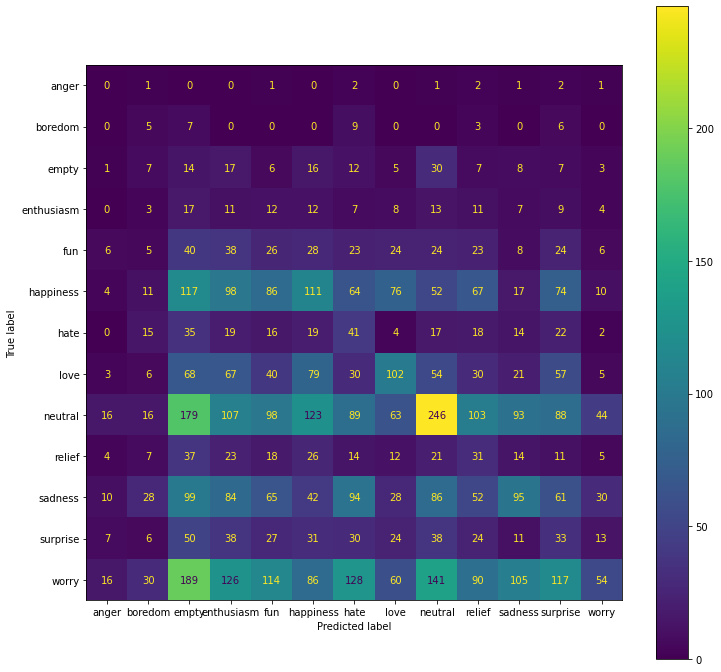

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        11
     boredom       0.04      0.17      0.06        30
       empty       0.02      0.11      0.03       133
  enthusiasm       0.02      0.10      0.03       114
         fun       0.05      0.09      0.07       275
   happiness       0.19      0.14      0.16       787
        hate       0.08      0.18      0.11       222
        love       0.25      0.18      0.21       562
     neutral       0.34      0.19      0.25      1265
      relief       0.07      0.14      0.09       223
     sadness       0.24      0.12      0.16       774
    surprise       0.06      0.10      0.08       332
       worry       0.31      0.04      0.08      1256

    accuracy                           0.13      5984
   macro avg       0.13      0.12      0.10      5984
weighted avg       0.23      0.13      0.15      5984



In [30]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

param_grid = {
    "n_neighbors": [3, 5]
}
best_model = hyperparameter_tuning(knn, param_grid)
results = model_validation(best_model)
print("Cross Validation results", results)
final_model, report = train_model(best_model)
print(report)

### 4.2.3 Decision Trees

Fitting 2 folds for each of 12 candidates, totalling 24 fits
 Results from Grid Search 

 The best estimator across ALL searched params:
 DecisionTreeClassifier(max_depth=500)

 The best score across ALL searched params:
 0.30367496853269504

 The best parameters across ALL searched params:
 {'max_depth': 500, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Cross Validation results {'fit_time': array([8.15396523, 8.07943487, 8.17320228, 8.14586592, 8.36578584]), 'score_time': array([0.21966124, 0.23520231, 0.23470163, 0.23570156, 0.23520255]), 'test_accuracy': array([0.38620654, 0.36873872, 0.37188548, 0.36492133, 0.37023472]), 'test_precision_macro': array([0.48164687, 0.43584126, 0.43406049, 0.40573615, 0.41969482]), 'test_recall_macro': array([0.38620087, 0.3690311 , 0.37016897, 0.3639135 , 0.3699428 ]), 'test_f1_macro': array([0.40140847, 0.3830905 , 0.38061564, 0.36890004, 0.37701112])}
Accuracy Score on training set is 91.32 %
Accuracy Score on validation set i

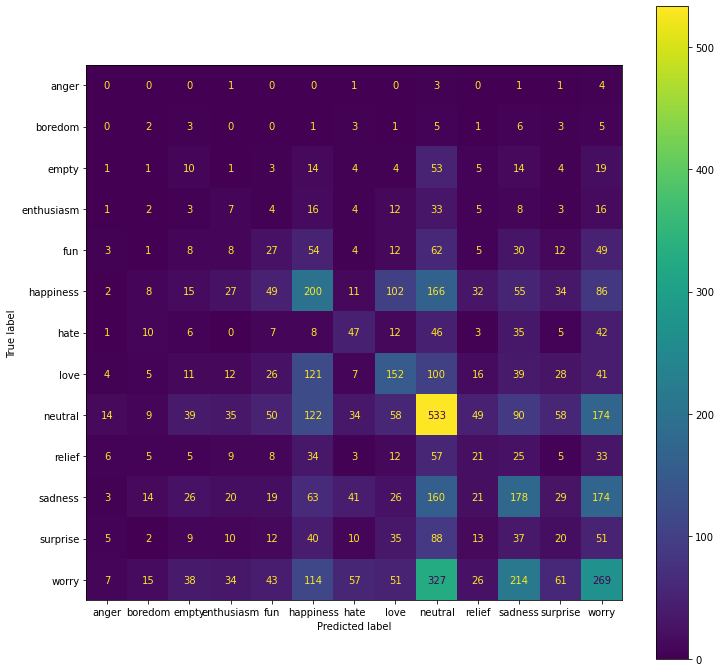

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        11
     boredom       0.03      0.07      0.04        30
       empty       0.06      0.08      0.07       133
  enthusiasm       0.04      0.06      0.05       114
         fun       0.11      0.10      0.10       275
   happiness       0.25      0.25      0.25       787
        hate       0.21      0.21      0.21       222
        love       0.32      0.27      0.29       562
     neutral       0.33      0.42      0.37      1265
      relief       0.11      0.09      0.10       223
     sadness       0.24      0.23      0.24       774
    surprise       0.08      0.06      0.07       332
       worry       0.28      0.21      0.24      1256

    accuracy                           0.24      5984
   macro avg       0.16      0.16      0.16      5984
weighted avg       0.25      0.24      0.24      5984



In [31]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()

param_grid = {
    "max_depth": [100, 500],
    "splitter": ['best'],
    "min_samples_split": [2, 4],
    "min_samples_leaf": [1, 2, 4]
}
best_model = hyperparameter_tuning(dtree, param_grid)
results = model_validation(best_model)
print("Cross Validation results", results)
final_model, report = train_model(best_model)
print(report)

### 4.2.4 Random Forest

Fitting 2 folds for each of 2 candidates, totalling 4 fits
 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=200)

 The best score across ALL searched params:
 0.20448589645709098

 The best parameters across ALL searched params:
 {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 200}


C:\Users\irvin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\irvin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\irvin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cross Validation results {'fit_time': array([6.74391556, 6.82663703, 6.90007544, 6.78401971, 6.7780304 ]), 'score_time': array([0.49854946, 0.50333428, 0.50505733, 0.50114155, 0.5015347 ]), 'test_accuracy': array([0.22407923, 0.20876967, 0.21005932, 0.20397214, 0.21434099]), 'test_precision_macro': array([0.43693573, 0.43495681, 0.39000955, 0.32964667, 0.36470495]), 'test_recall_macro': array([0.21583604, 0.19948635, 0.20148967, 0.19532785, 0.20651154]), 'test_f1_macro': array([0.20123115, 0.17266025, 0.17593133, 0.16980193, 0.17040158])}
Accuracy Score on training set is 30.94 %
Accuracy Score on validation set is 20.67 %


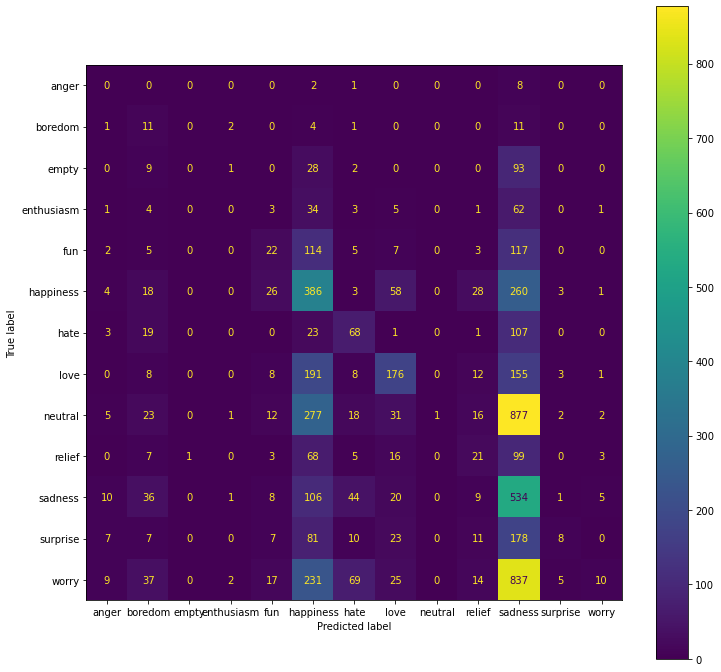

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        11
     boredom       0.06      0.37      0.10        30
       empty       0.00      0.00      0.00       133
  enthusiasm       0.00      0.00      0.00       114
         fun       0.21      0.08      0.12       275
   happiness       0.25      0.49      0.33       787
        hate       0.29      0.31      0.30       222
        love       0.49      0.31      0.38       562
     neutral       1.00      0.00      0.00      1265
      relief       0.18      0.09      0.12       223
     sadness       0.16      0.69      0.26       774
    surprise       0.36      0.02      0.05       332
       worry       0.43      0.01      0.02      1256

    accuracy                           0.21      5984
   macro avg       0.26      0.18      0.13      5984
weighted avg       0.45      0.21      0.14      5984



In [32]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

param_grid = {
    "n_estimators": [100, 200],
    "criterion": ['entropy'],
    "max_depth": [10]
}
best_model = hyperparameter_tuning(rf, param_grid)
results = model_validation(best_model)
print("Cross Validation results", results)
final_model, report = train_model(best_model)
print(report)

### 4.2.5 AdaBoost

Fitting 2 folds for each of 18 candidates, totalling 36 fits
 Results from Grid Search 

 The best estimator across ALL searched params:
 AdaBoostClassifier(n_estimators=200)

 The best score across ALL searched params:
 0.19397272145760686

 The best parameters across ALL searched params:
 {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 200}
Cross Validation results {'fit_time': array([26.52188468, 26.57961607, 26.47807908, 26.47932935, 26.42207837]), 'score_time': array([1.08508468, 1.08276963, 1.08951378, 1.08909869, 1.0840292 ]), 'test_accuracy': array([0.21071908, 0.20804746, 0.20521021, 0.19824607, 0.20304359]), 'test_precision_macro': array([0.22721924, 0.23412463, 0.22108575, 0.21757259, 0.22179936]), 'test_recall_macro': array([0.21137956, 0.20905964, 0.20596154, 0.19897096, 0.20375086]), 'test_f1_macro': array([0.20627225, 0.20461827, 0.1989957 , 0.19192947, 0.19549254])}
Accuracy Score on training set is 24.95 %
Accuracy Score on validation set is 24.01 %


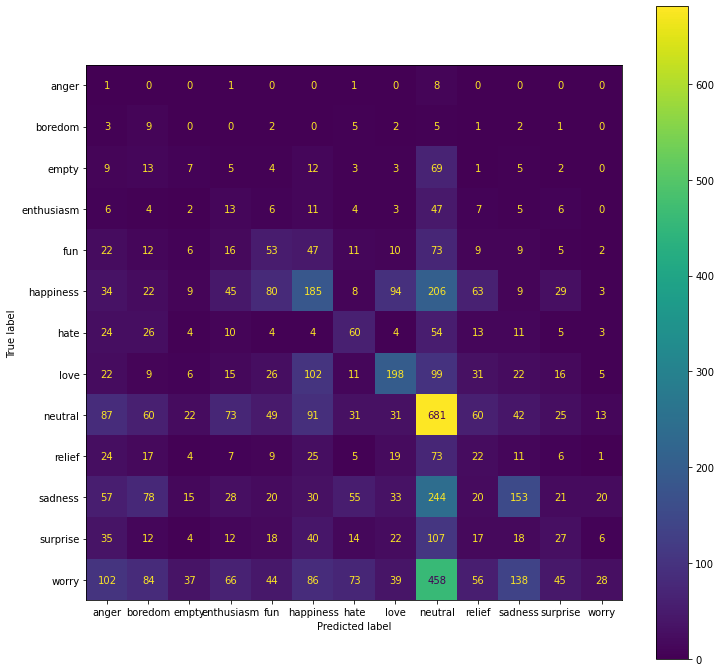

              precision    recall  f1-score   support

       anger       0.00      0.09      0.00        11
     boredom       0.03      0.30      0.05        30
       empty       0.06      0.05      0.06       133
  enthusiasm       0.04      0.11      0.06       114
         fun       0.17      0.19      0.18       275
   happiness       0.29      0.24      0.26       787
        hate       0.21      0.27      0.24       222
        love       0.43      0.35      0.39       562
     neutral       0.32      0.54      0.40      1265
      relief       0.07      0.10      0.08       223
     sadness       0.36      0.20      0.26       774
    surprise       0.14      0.08      0.10       332
       worry       0.35      0.02      0.04      1256

    accuracy                           0.24      5984
   macro avg       0.19      0.20      0.16      5984
weighted avg       0.29      0.24      0.23      5984



In [33]:
from sklearn.ensemble import AdaBoostClassifier

ab = AdaBoostClassifier()

param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.1, 0.5, 1.0],
    "algorithm": ['SAMME', 'SAMME.R']
}
best_model = hyperparameter_tuning(ab, param_grid)
results = model_validation(best_model)
print("Cross Validation results", results)
final_model, report = train_model(best_model)
print(report)

### 4.2.6 Gaussian Naive Bayes

Cross Validation results {'fit_time': array([2.13703489, 2.15497065, 2.17746878, 2.08379459, 2.0981257 ]), 'score_time': array([0.48723865, 0.48319697, 0.50380397, 0.49172568, 0.52580333]), 'test_accuracy': array([0.14427938, 0.18209956, 0.17776631, 0.16688161, 0.15656435]), 'test_precision_macro': array([0.17326941, 0.22459289, 0.22377571, 0.21134809, 0.20342352]), 'test_recall_macro': array([0.14537304, 0.18478906, 0.18015869, 0.16904642, 0.15930733]), 'test_f1_macro': array([0.14218575, 0.17126668, 0.16731034, 0.1582855 , 0.1518601 ])}
Accuracy Score on training set is 18.6 %
Accuracy Score on validation set is 18.32 %


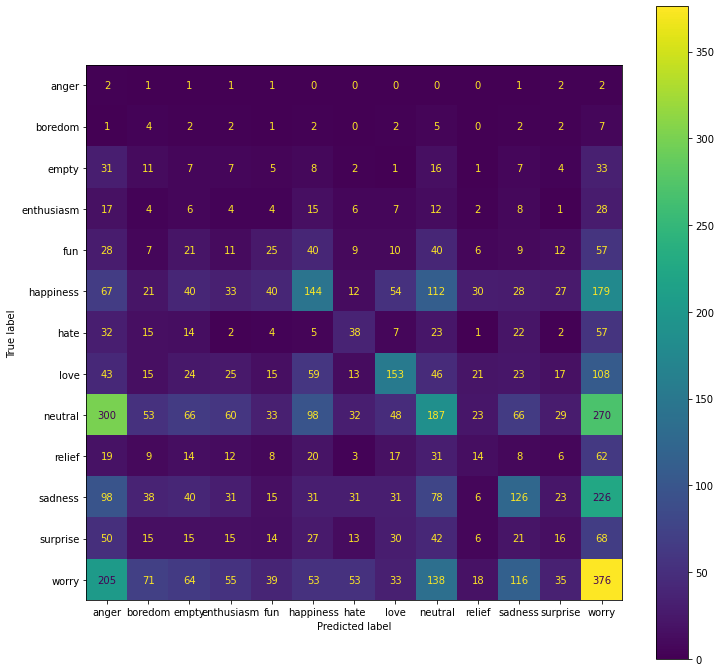

              precision    recall  f1-score   support

       anger       0.00      0.18      0.00        11
     boredom       0.02      0.13      0.03        30
       empty       0.02      0.05      0.03       133
  enthusiasm       0.02      0.04      0.02       114
         fun       0.12      0.09      0.10       275
   happiness       0.29      0.18      0.22       787
        hate       0.18      0.17      0.18       222
        love       0.39      0.27      0.32       562
     neutral       0.26      0.15      0.19      1265
      relief       0.11      0.06      0.08       223
     sadness       0.29      0.16      0.21       774
    surprise       0.09      0.05      0.06       332
       worry       0.26      0.30      0.28      1256

    accuracy                           0.18      5984
   macro avg       0.16      0.14      0.13      5984
weighted avg       0.24      0.18      0.20      5984



In [27]:
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import TruncatedSVD

nb = Pipeline([
    ('svd', TruncatedSVD(n_components=200)),
    ('nb', GaussianNB()),])

results = model_validation(nb)
print("Cross Validation results", results)
final_model, report = train_model(nb)
print(report)

## 4.3 Export Vectorizer and ML Model

In [34]:
import pickle
from joblib import dump, load

final_vectorizer_params = {
    "smooth_idf": True,
    "analyzer": 'word',
    "stop_words": 'english',
    "lowercase": True,
    "ngram_range": (1,2),
    "max_features": 1200,
}

tfidf_vectorizer = TfidfVectorizer(**final_vectorizer_params)

tfidf_vectorizer.fit(train_df['content'])

final_model_params = {
    'n_neighbors': 3
}

final_model_knn = KNeighborsClassifier(**final_model_params)

final_model_knn.fit(X,y)

KNeighborsClassifier(n_neighbors=3)

### Export Model and Vectorizer

In [35]:
# Save Vectorizerto file 
with open('../models/vectorizer_tfidf-os.pickle', 'wb') as fin:
    pickle.dump(tfidf_vectorizer, fin)

# Save Model to file
dump(final_model_knn, '../models/SA_NLP_Model-os.joblib')

['../models/SA_NLP_Model-os.joblib']

# TESTING


In [36]:
import sys
import pickle
import joblib

def load_model():
    with open(r"../models/vectorizer_tfidf-os.pickle", "rb") as input_file:
        vectorizer = pickle.load(input_file)

    loaded_model = joblib.load('../models/SA_NLP_Model-os.joblib')
    
    return vectorizer, loaded_model

with open('../tweet.txt') as f:
     lines = f.readlines()
print('The input text is: ', lines[0])
    
vec, model = load_model()

test_vec = vec.transform(lines)
# print(X)
    
print('The predicted sentiment is:', model.predict(test_vec)[0])

The input text is:  this is what happens when you don't recycle your pizza boxes
The predicted sentiment is: love
